# How to distribute simulation across multiple processors


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.no_transport import (
    ForcingParameter,
    ForcingUnit,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
    MigratoryTypeParameter,
    NoTransportConfiguration,
)
from seapopym.model import NoTransportModel
from seapopym.standard.coordinate_authority import (
    create_latitude_coordinate,
    create_layer_coordinate,
    create_longitude_coordinate,
    create_time_coordinate,
)
from seapopym.standard.units import StandardUnitsLabels


## Initialize the dask client


In [2]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(dashboard_address="8788")

client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8788/status,
Dashboard: http://127.0.0.1:8788/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60193,Workers: 0
Dashboard: http://127.0.0.1:8788/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:60204,Total threads: 3
Dashboard: http://127.0.0.1:60209/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:60196,


## Generating data for the 1D simulation

Let's generate some data for the 1D simulation. In this NoTransport model, only temperature and primary production are required. The temperature is generated as a sine wave with a period of 1 year and the primary production is randomly generated.


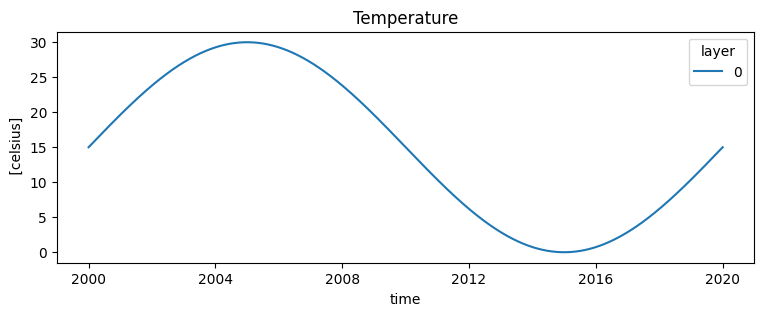

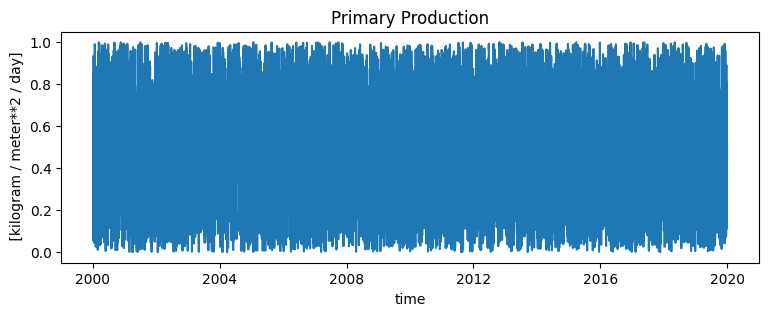

In [3]:
time_start = pd.Timestamp("2000-01-01")
time_end = pd.Timestamp("2020-01-01")

T_axis = create_time_coordinate(pd.date_range(time_start, time_end, freq="D"))
n = int(T_axis.size)
t = np.linspace(0, 1, n)
temperature = 15 + 15 * np.sin(2 * np.pi * t)
primary_production = 10 + 5 * np.sin(2 * np.pi * t * 365)

temperature = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(pd.date_range(time_start, time_end, freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data=temperature[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
temperature[:, 0, 0].cf.plot.line(x="T")
plt.title("Temperature")
plt.show()

primary_production = xr.DataArray(
    dims=["T", "Y", "X"],
    coords={
        "T": create_time_coordinate(pd.date_range(time_start, time_end, freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.production},
    data=np.random.rand(create_time_coordinate(pd.date_range(time_start, time_end, freq="D")).size, 1, 1),
)

plt.figure(figsize=(9, 3))
primary_production.plot()
plt.title("Primary Production")
plt.show()

dataset = xr.Dataset({"temperature": temperature, "primary_production": primary_production})

## Create the forcing parameter


In [4]:
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"]),
    primary_production=ForcingUnit(forcing=dataset["primary_production"]),
)

## Scatter the forcing to the workers (each worker will have its own copy)


In [5]:
scattered_forcing = client.scatter(p_param, broadcast=True)


## Simulation function


In [6]:
def optimized_simulation_function(args):
    x, forcing_param = args

    f_groups = generate_fg_config(x)
    config = NoTransportConfiguration(forcing=forcing_param, functional_group=f_groups)

    with NoTransportModel.from_configuration(config) as model:
        model.run()
        mean_biomass = model.state["biomass"].mean().load()
    return mean_biomass


## Generate all the configurations


In [7]:
def generate_fg_config(x):
    day_layer = 0
    night_layer = 0
    tr_0 = (x % 50) + 1
    gamma_tr = -0.11
    lambda_temperature_0 = 1 / 150
    gamma_lambda_temperature = 0.15

    f_groups = FunctionalGroupParameter(
        functional_group=[
            FunctionalGroupUnit(
                name=f"D{day_layer}N{night_layer}",
                energy_transfert=0.1668,
                migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
                functional_type=FunctionalTypeParameter(
                    lambda_temperature_0=lambda_temperature_0,
                    gamma_lambda_temperature=gamma_lambda_temperature,
                    tr_0=tr_0,
                    gamma_tr=gamma_tr,
                ),
            ),
            FunctionalGroupUnit(
                name=f"D{day_layer}N{night_layer}_BIS",
                energy_transfert=0.1668 / 2,
                migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
                functional_type=FunctionalTypeParameter(
                    lambda_temperature_0=lambda_temperature_0 / 2,
                    gamma_lambda_temperature=gamma_lambda_temperature / 2,
                    tr_0=tr_0,
                    gamma_tr=gamma_tr / 2,
                ),
            ),
        ],
    )
    return f_groups


In [8]:
simulation_args = [(x, scattered_forcing) for x in range(10_000)]

## Finally, run the simulations

Follow the execution with the Dask client dashboard.


In [9]:
result = client.map(optimized_simulation_function, simulation_args)
result = client.gather(result)